In [40]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

# Loading coloumn names
df1 = pd.read_csv('../hai-21.03/train1.csv', nrows=1)
df2 = pd.read_csv('../hai-22.04/train2.csv', nrows=1)
df3 = pd.read_csv('../hai-23.05/hai-train3.csv', nrows=1)

# Get sets of column names
cols1 = set(df1.columns)
cols2 = set(df2.columns)
cols3 = set(df3.columns)

# Find common columns across all three datasets
common_cols = cols1 & cols2 & cols3

print(common_cols)

{'P4_ST_FD', 'P1_PCV01Z', 'P1_PP02D', 'P1_LIT01', 'P1_FCV01Z', 'P1_PP01AR', 'P1_LCV01Z', 'P2_VTR04', 'P3_FIT01', 'P2_RTR', 'P1_FCV02D', 'P2_OnOff', 'P1_FT03', 'P2_VTR02', 'P1_LCV01D', 'P2_VT01', 'P1_PCV02D', 'P1_FT01', 'P4_ST_PT01', 'P4_HT_PS', 'P4_LD', 'P1_FCV02Z', 'P1_PP01AD', 'P3_LCV01D', 'P1_FT02Z', 'P1_STSP', 'P1_FCV03D', 'P4_ST_PS', 'P2_TripEx', 'P2_VTR03', 'P3_LIT01', 'P4_HT_FD', 'P1_FT02', 'P4_HT_PO', 'P1_FCV01D', 'P2_VTR01', 'P4_ST_TT01', 'P1_PP01BD', 'P4_ST_LD', 'P1_FT03Z', 'P1_PIT02', 'P1_PP01BR', 'P1_TIT01', 'P2_AutoGO', 'P2_SIT01', 'P1_PP02R', 'P1_TIT02', 'P2_ManualGO', 'P1_FT01Z', 'P4_ST_PO', 'P1_FCV03Z', 'P3_PIT01', 'P4_ST_GOV', 'P1_PCV02Z', 'P3_LCP01D', 'P1_PCV01D', 'P2_Emerg', 'P1_PIT01', 'P2_24Vdc'}


In [41]:
sensors = [col for col in common_cols if any(x in col for x in [
    'PIT', 'TIT', 'LIT', 'FT', 'FIT', 'VT', 'SIT', 'TT', 'PT', 'FD', 'LD', 'PO', 'PS'
])]
actuators = [col for col in common_cols if any(x in col for x in [
    'FCV', 'LCV', 'PCV', 'PP', 'Auto', 'On', 'Emgy', 'Trip'
])]

print(f"Sensors: {sensors}")
print(f"Actuators: {actuators}")

Sensors: ['P4_ST_FD', 'P1_LIT01', 'P2_VTR04', 'P3_FIT01', 'P1_FT03', 'P2_VTR02', 'P2_VT01', 'P1_FT01', 'P4_ST_PT01', 'P4_HT_PS', 'P4_LD', 'P1_FT02Z', 'P4_ST_PS', 'P2_VTR03', 'P3_LIT01', 'P4_HT_FD', 'P1_FT02', 'P4_HT_PO', 'P2_VTR01', 'P4_ST_TT01', 'P4_ST_LD', 'P1_FT03Z', 'P1_PIT02', 'P1_TIT01', 'P2_SIT01', 'P1_TIT02', 'P1_FT01Z', 'P4_ST_PO', 'P3_PIT01', 'P1_PIT01']
Actuators: ['P1_PCV01Z', 'P1_PP02D', 'P1_FCV01Z', 'P1_PP01AR', 'P1_LCV01Z', 'P1_FCV02D', 'P2_OnOff', 'P1_LCV01D', 'P1_PCV02D', 'P1_FCV02Z', 'P1_PP01AD', 'P3_LCV01D', 'P1_FCV03D', 'P2_TripEx', 'P1_FCV01D', 'P1_PP01BD', 'P1_PP01BR', 'P2_AutoGO', 'P1_PP02R', 'P1_FCV03Z', 'P1_PCV02Z', 'P1_PCV01D']


In [42]:

hai_21_files = sorted(glob("../hai-21.03/train*.csv")) + sorted(glob("../hai-21.03/test*.csv"))
hai_22_files = sorted(glob("../hai-22.04/train*.csv")) + sorted(glob("../hai-22.04/test*.csv"))
hai_23_files = sorted(glob("../hai-23.05/hai-train*.csv")) + sorted(glob("../hai-23.05/hai-test*.csv"))

hai_21_attack_cols = ['attack', 'attack_P1', 'attack_P2', 'attack_P3']

In [55]:

def load_and_clean(files, sensor_cols, attack_cols):
    """Load data, remove attack samples, and clean NaN values"""
    # Load sensor and attack columns
    df = pd.concat([pd.read_csv(f, usecols=sensor_cols + attack_cols) for f in files], ignore_index=True)
    
    # Remove attack samples (keep only rows where all attack columns are 0)
    df = df[(df[attack_cols] == 0).all(axis=1)]
    
    # Drop attack columns after filtering
    df = df.drop(columns=attack_cols)
    
    # Forward fill to handle any remaining NaN values
    #df = df.fillna(method='ffill')
    
    return df

def min_max_normalize(df):
    """Min-Max normalization to [0, 1] range"""
    return (df - df.min()) / (df.max() - df.min())


def empirical_cdf(sample):
    sorted_x = np.sort(sample)
    y = np.arange(1, len(sorted_x)+1) / len(sorted_x)
    return sorted_x, y

def ks_statistic(sample1, sample2):
    if len(sample1) == 0 or len(sample2) == 0:
        return np.nan
    x1, F1 = empirical_cdf(sample1)
    x2, F2 = empirical_cdf(sample2)
    all_x = np.sort(np.unique(np.concatenate([x1, x2])))
    F1_all = np.searchsorted(x1, all_x, side="right") / len(x1)
    F2_all = np.searchsorted(x2, all_x, side="right") / len(x2)
    D = np.max(np.abs(F1_all - F2_all))
    return D

def compare_datasets(dfA, dfB):
    ks_values = {}
    for col in dfA.columns:
        D = ks_statistic(dfA[col], dfB[col])
        ks_values[col] = D
    return ks_values

Add attack labels to dataset of 23 from lebel file

In [80]:
df23 = []
file_pairs = [
    ("../hai-23.05/hai-test1.csv", "../hai-23.05/label-test1.csv"),
    ("../hai-23.05/hai-test2.csv", "../hai-23.05/label-test2.csv")
]
for test_file, label_file in file_pairs:
    # Load files
    test_df = pd.read_csv(test_file)
    label_df = pd.read_csv(label_file)

    # Merge on timestamp
    merged = pd.merge(test_df, label_df, on='timestamp', how='left')

    # Create attack column
    merged['attack'] = merged['label'].fillna(0).astype(int)
    merged.drop(columns=['label'], inplace=True)

    df23.append(merged)
df23 = pd.concat(df23, ignore_index=True)
df23= df23[sensors]


In [81]:
df21 = load_and_clean(hai_21_files, sensors, hai_21_attack_cols)
df22 = load_and_clean(hai_22_files, sensors, ['Attack'])

df21_normalized = min_max_normalize(df21)
df22_normalized = min_max_normalize(df22)
df23_normalized = min_max_normalize(df23)



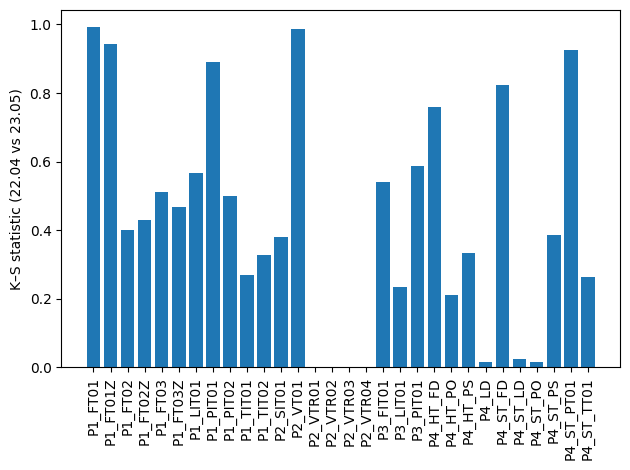

In [82]:
ks_21_22 = compare_datasets(df21_normalized, df22_normalized)
ks_22_23 = compare_datasets(df22_normalized, df23_normalized)

# # Plot ECDFs for P1_FT01 and P1_FT01Z
# x1, F1 = empirical_cdf(df21_normalized['P1_FT01'])
# x2, F2 = empirical_cdf(df21_normalized['P1_FT01Z'])
# plt.step(x1, F1, label='P1_FT01')
# plt.step(x2, F2, label='P1_FT01Z')
# plt.xlabel('Value')
# plt.ylabel('ECDF')
# plt.title('ECDF Comparison')
# plt.legend()
# plt.show()

# # Optional: plot histograms for reference
# plt.hist(df21_normalized['P1_FT01'], bins=50, alpha=0.5, label='P1_FT01')
# plt.hist(df21_normalized['P1_FT01Z'], bins=50, alpha=0.5, label='P1_FT01Z')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram Comparison')
# plt.legend()
# plt.show()

# Bar plot for KS statistics
plt.bar(range(len(ks_22_23)), list(ks_22_23.values()))
plt.xticks(range(len(ks_22_23)), list(ks_22_23.keys()), rotation=90)
plt.ylabel("K–S statistic (22.04 vs 23.05)")
plt.tight_layout()
plt.show()